In [124]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt 
%matplotlib inline

In [125]:
# read in all the words
words = open("names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [126]:
len(words)

32033

In [127]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)

print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [128]:
# build the dataset
block_size = (
    3  # context length: how many characters do we take to predict the next one?
)


def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


import random

random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])  # 80%
Xdev, Ydev = build_dataset(words[n1:n2])  # 10%
Xte, Yte = build_dataset(words[n2:])  # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [129]:
# MLP revisited
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)  # for reproducibility

C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = (
    torch.randn((n_hidden, vocab_size), generator=g) 
)  
b2 = torch.randn(vocab_size, generator=g) 

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))  # number of parameters in total

for p in parameters:
    p.requires_grad = True

11897


## training for one step

In [130]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y

    # forward pass
    emb = C[Xb]  # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1)  # concatenate the vectors
    hpreact = embcat @ W1 + b1  # hidden layer pre-activation
    h = torch.tanh(hpreact)  # hidden layer
    logits = h @ W2 + b2  # output layer
    loss = F.cross_entropy(logits, Yb)  # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:  # print every once in a while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    break # training for one step

      0/ 200000: 27.8817


In [131]:
h
# tanh squashing function 
# squashes values bw -1 and 1 

tensor([[ 0.8100, -0.8997, -0.9993,  ..., -0.9097, -1.0000,  1.0000],
        [-1.0000, -0.9571, -0.7145,  ...,  0.4898,  0.9090,  0.9937],
        [ 0.9983, -0.3340,  1.0000,  ...,  0.9443,  0.9905,  1.0000],
        ...,
        [-1.0000,  0.9604, -0.1418,  ..., -0.1266,  1.0000,  1.0000],
        [-1.0000, -0.4385, -0.8882,  ..., -0.3316,  0.9995,  1.0000],
        [-1.0000,  0.9604, -0.1418,  ..., -0.1266,  1.0000,  1.0000]],
       grad_fn=<TanhBackward0>)

In [132]:
h.shape

torch.Size([32, 200])

(array([2069.,  144.,  106.,   82.,   59.,   56.,   43.,   31.,   43.,
          26.,   16.,   38.,   16.,   32.,   24.,   14.,   28.,   27.,
          26.,   19.,   24.,   26.,   30.,   14.,   19.,   19.,   22.,
          26.,   18.,   12.,   10.,   33.,   27.,   32.,   17.,   24.,
          30.,   22.,   26.,   29.,   26.,   40.,   29.,   41.,   49.,
          64.,   62.,  100.,  188., 2442.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

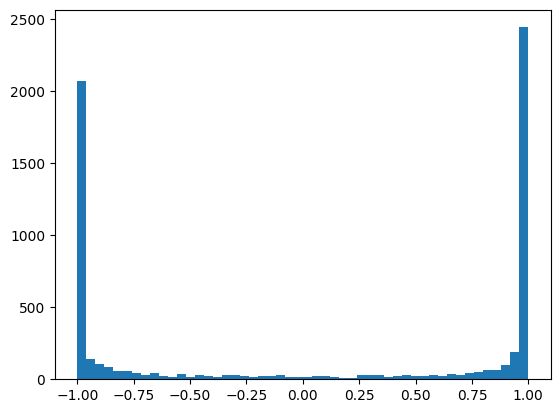

In [133]:
plt.hist(h.view(-1).tolist(), 50)
# -1 means figure out this dimension automatically so that the total number of elements stays the same.


# this is big issue in backprop because :
# This is backprop of tanh:
# --------------
# def tanh(self):
#     x = self.data
#     t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
#     out = Value(t, (self,), "tanh")

#     def _backward():
#         self.grad += (1 - t**2) * out.grad

#     out._backward = _backward
#     return out
# --------------
# WHEN OUTPUT OF TANH IS -1 OR 1 --> WE ARE BASICALLY ZERO OUT THE GRADIENTS UPDATE (1 - t**2)
# THIS PREVENTS MODEL TRAINING 

(array([  2.,   2.,   1.,   4.,   2.,   4.,   6.,  15.,   5.,  25.,  32.,
         49.,  56.,  59.,  92., 119., 134., 197., 195., 221., 257., 275.,
        297., 341., 353., 375., 369., 349., 358., 362., 271., 312., 229.,
        206., 190., 167.,  87., 111.,  72.,  55.,  41.,  22.,  23.,  18.,
         17.,   8.,   5.,   7.,   2.,   1.]),
 array([-19.05793762, -18.31571915, -17.57350067, -16.8312822 ,
        -16.08906372, -15.34684525, -14.60462677, -13.86240829,
        -13.12018982, -12.37797134, -11.63575287, -10.89353439,
        -10.15131592,  -9.40909744,  -8.66687897,  -7.92466049,
         -7.18244202,  -6.44022354,  -5.69800507,  -4.95578659,
         -4.21356812,  -3.47134964,  -2.72913116,  -1.98691269,
         -1.24469421,  -0.50247574,   0.23974274,   0.98196121,
          1.72417969,   2.46639816,   3.20861664,   3.95083511,
          4.69305359,   5.43527206,   6.17749054,   6.91970901,
          7.66192749,   8.40414597,   9.14636444,   9.88858292,
         10.630801

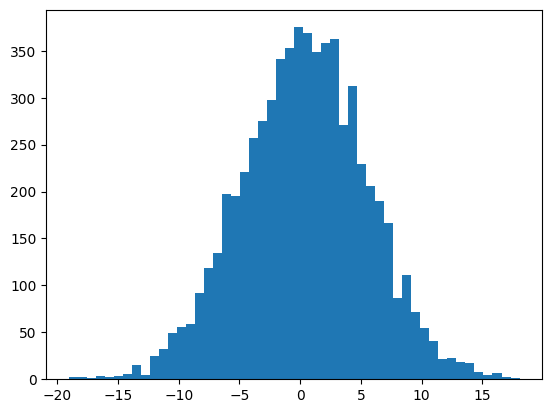

In [134]:
plt.hist(hpreact.view(-1).tolist(), 50)

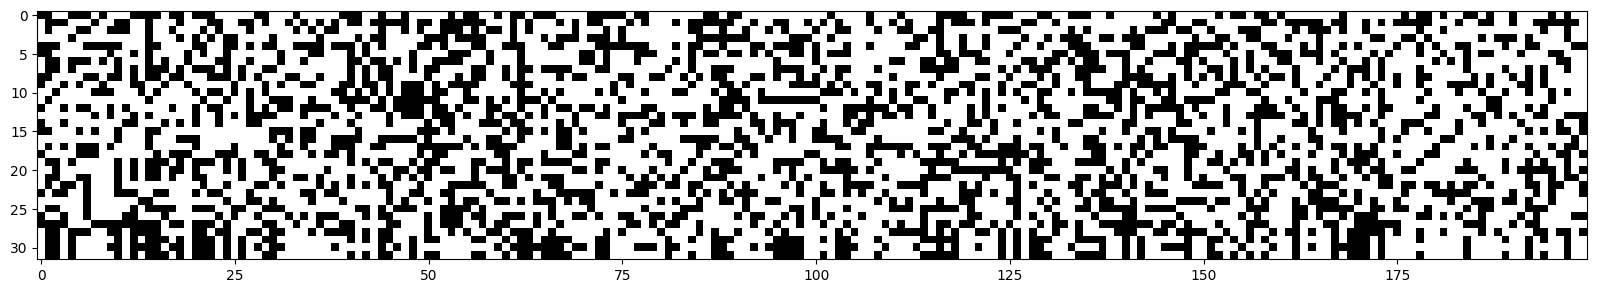

In [135]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap="gray", interpolation="nearest")
# alot of gradients getting destroyed

# if there is complete columns of white means that for that char the neuron never learns / dead neuron
# all values land in tail part of tanh and grad never flows
# here for some values neuron do learn
# this can also happens during optimzation , (brain-damaged neuron) -> they get knocked off becuase after update all input squashes their actication/ no update

# sigmoid /relu has same issue 
# as it a squashing neuron

# leaky relu doesnt suffer from it

# SOLUTION: WE WANT HPREACT ACTICATIONS TO BE CLOSE TO 0 (not majority of them being -1 or 1)

In [136]:
logits[0] # very extreme values , creating fake confidence and increasing loss 
# should be close to 0 

tensor([ -2.3527,  36.4366, -10.7306,   5.7165,  18.6409, -11.6998,  -2.1991,
          1.8535,  10.9996,  10.6730,  12.3507, -10.3809,   4.7243, -24.4257,
         -8.5909,   1.9024, -12.2744, -12.4751, -23.2778,  -2.0163,  25.8767,
         14.2108,  17.7691, -10.9204, -20.7335,   6.4560,  11.1615],
       grad_fn=<SelectBackward0>)

big loss at initialization :  0/ 200000: 27.8817

we expect initial probability ditribution to be likely for every chars

In [137]:
# log loss we expect for equal probability, rightnow initialisation is biased for some chars
-torch.tensor(1/27.0).log()

tensor(3.2958)

In [138]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y

    # forward pass
    emb = C[Xb]  # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1)  # concatenate the vectors
    hpreact = embcat @ W1 + b1  # hidden layer pre-activation
    h = torch.tanh(hpreact)  # hidden layer
    logits = h @ W2 + b2  # output layer
    loss = F.cross_entropy(logits, Yb)  # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:  # print every once in a while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 24.0032
  10000/ 200000: 2.0880
  20000/ 200000: 2.1624
  30000/ 200000: 2.2546
  40000/ 200000: 2.4214
  50000/ 200000: 2.2139
  60000/ 200000: 2.2026
  70000/ 200000: 2.7599
  80000/ 200000: 2.7701
  90000/ 200000: 2.2262
 100000/ 200000: 2.4470
 110000/ 200000: 1.9246
 120000/ 200000: 2.2257
 130000/ 200000: 1.9610
 140000/ 200000: 1.8164
 150000/ 200000: 2.6429
 160000/ 200000: 2.2522
 170000/ 200000: 1.7424
 180000/ 200000: 1.9715
 190000/ 200000: 2.0900


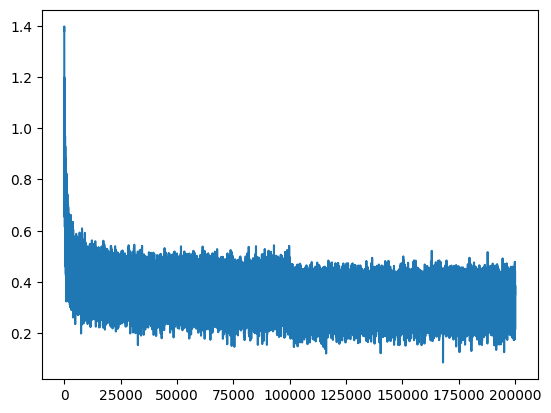

In [139]:
plt.plot(lossi)
# took away nn part of squashing weights in initial steps
# no longer a hockey stick because we took away high initiliation at random and make all values closer to 0 / equal / no bias for any chars at random

In [140]:
@torch.no_grad()  # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]

    emb = C[x]  # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1)  # concat into (N, block_size * n_embd)
    h = torch.tanh(embcat @ W1 + b1)  # (N, n_hidden)
    logits = h @ W2 + b2  # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

# faster convergence and better results because we are spending more steps optimising nn instead of squashing weights
split_loss("train")
split_loss("val")

train 2.125521183013916
val 2.1683576107025146


In [141]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size  # initialize with all ...

    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])]  # (1, block_size, n_embd)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)

        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()

        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)

        # if we sample the special '.' token, break
        if ix == 0:
            break

    # decode and print the generated word
    print("".join(itos[i] for i in out))

carlah.
amille.
khirmoni.
taty.
skanden.
jazonen.
den.
art.
kaqui.
nellara.
chaiir.
kaleigh.
ham.
jorn.
quint.
salin.
alianni.
wazthoniearyn.
kai.
eveirsat.


# fixed activations issues 

In [142]:
# MLP revisited
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)  # for reproducibility

C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden, generator=g) * 0.01 # little bit of entropy / variation
W2 = (
    torch.randn((n_hidden, vocab_size), generator=g) * 0.01
)  # need no bias at initialisation,
# shouldnt do 0 because
b2 = torch.randn(vocab_size, generator=g) * 0  # w2 impacts logits hence decreasing

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))  # number of parameters in total

for p in parameters:
    p.requires_grad = True

11897


### training for one step to see initial loss


In [143]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y

    # forward pass
    emb = C[Xb]  # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1)  # concatenate the vectors
    hpreact = embcat @ W1 + b1  # hidden layer pre-activation
    h = torch.tanh(hpreact)  # hidden layer
    logits = h @ W2 + b2  # output layer
    loss = F.cross_entropy(logits, Yb)  # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:  # print every once in a while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    break

      0/ 200000: 3.3135


(array([143., 172., 172., 161., 142., 151., 133., 116., 116., 143.,  95.,
        104., 126., 111., 119.,  91.,  86.,  90., 115., 100., 112., 122.,
        111.,  77., 103., 119., 100., 106.,  91.,  90., 117., 114., 116.,
        115., 107., 131., 111., 109., 114., 118., 142., 127., 162., 169.,
        152., 197., 184., 192., 208., 198.]),
 array([-9.98924255e-01, -9.58988956e-01, -9.19053657e-01, -8.79118358e-01,
        -8.39183059e-01, -7.99247760e-01, -7.59312460e-01, -7.19377161e-01,
        -6.79441862e-01, -6.39506563e-01, -5.99571264e-01, -5.59635965e-01,
        -5.19700665e-01, -4.79765366e-01, -4.39830067e-01, -3.99894768e-01,
        -3.59959469e-01, -3.20024170e-01, -2.80088871e-01, -2.40153571e-01,
        -2.00218272e-01, -1.60282973e-01, -1.20347674e-01, -8.04123747e-02,
        -4.04770756e-02, -5.41776419e-04,  3.93935227e-02,  7.93288219e-02,
         1.19264121e-01,  1.59199420e-01,  1.99134719e-01,  2.39070019e-01,
         2.79005318e-01,  3.18940617e-01,  3.58875

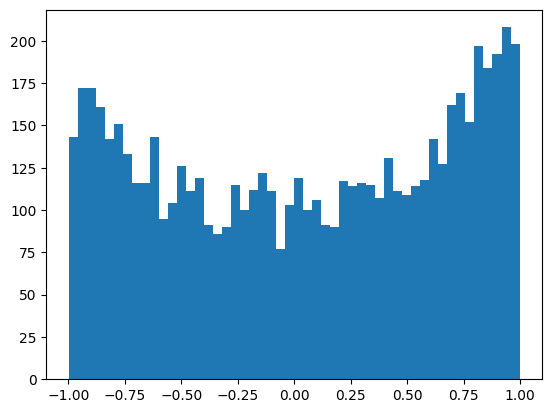

In [144]:
plt.hist(h.view(-1).tolist(), 50)

(array([  1.,   2.,   0.,   1.,   5.,   3.,  11.,   6.,  13.,  10.,  25.,
         40.,  40.,  77.,  63., 101., 127., 171., 184., 220., 227., 267.,
        312., 301., 356., 367., 376., 360., 370., 331., 298., 278., 292.,
        242., 191., 167., 137., 104.,  85.,  77.,  41.,  30.,  28.,  20.,
         11.,   7.,  11.,   5.,   2.,   7.]),
 array([-3.76367116, -3.6200974 , -3.47652364, -3.33294988, -3.18937612,
        -3.04580235, -2.90222859, -2.75865483, -2.61508107, -2.47150731,
        -2.32793355, -2.18435979, -2.04078603, -1.89721227, -1.75363851,
        -1.61006474, -1.46649098, -1.32291722, -1.17934346, -1.0357697 ,
        -0.89219594, -0.74862218, -0.60504842, -0.46147466, -0.3179009 ,
        -0.17432714, -0.03075337,  0.11282039,  0.25639415,  0.39996791,
         0.54354167,  0.68711543,  0.83068919,  0.97426295,  1.11783671,
         1.26141047,  1.40498424,  1.548558  ,  1.69213176,  1.83570552,
         1.97927928,  2.12285304,  2.2664268 ,  2.41000056,  2.55357432,
 

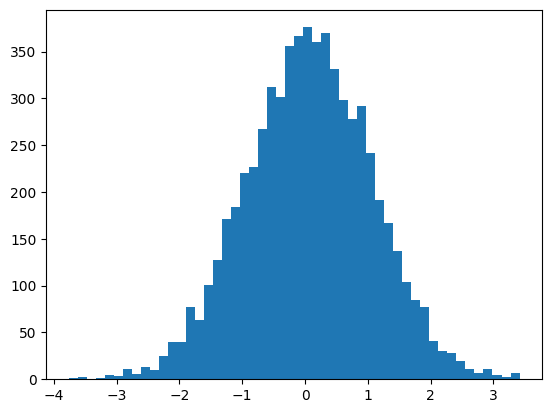

In [145]:
plt.hist(hpreact.view(-1).tolist(), 50)

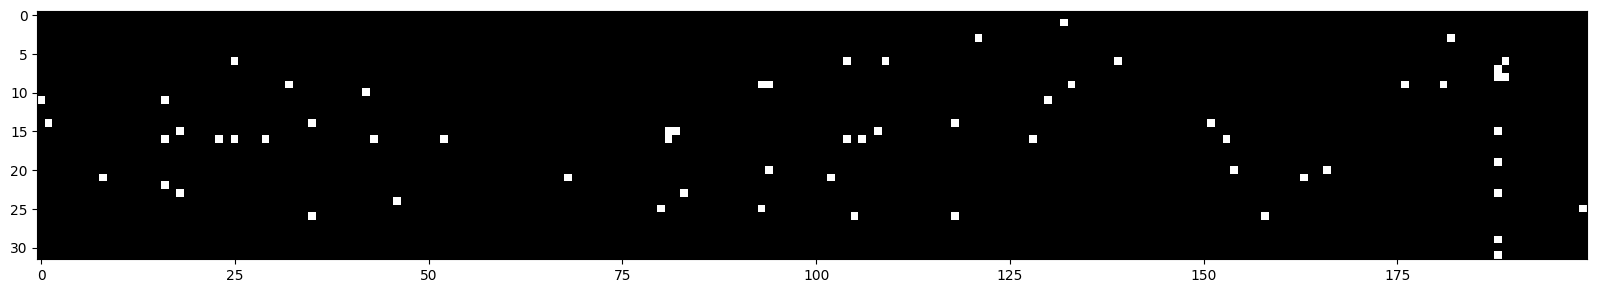

In [146]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap="gray", interpolation="nearest")

In [147]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y

    # forward pass
    emb = C[Xb]  # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1)  # concatenate the vectors
    hpreact = embcat @ W1 + b1  # hidden layer pre-activation
    h = torch.tanh(hpreact)  # hidden layer
    logits = h @ W2 + b2  # output layer
    loss = F.cross_entropy(logits, Yb)  # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:  # print every once in a while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 3.2465
  10000/ 200000: 1.9043
  20000/ 200000: 1.9004
  30000/ 200000: 1.9465
  40000/ 200000: 2.1656
  50000/ 200000: 2.0071
  60000/ 200000: 2.0826
  70000/ 200000: 2.4228
  80000/ 200000: 2.3109
  90000/ 200000: 2.1167
 100000/ 200000: 2.2166
 110000/ 200000: 1.8038
 120000/ 200000: 2.2112
 130000/ 200000: 1.9618
 140000/ 200000: 1.8056
 150000/ 200000: 2.4102
 160000/ 200000: 2.1829
 170000/ 200000: 1.6967
 180000/ 200000: 1.9343
 190000/ 200000: 2.1057


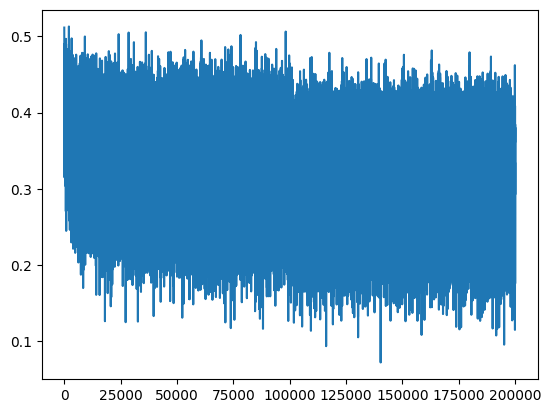

In [148]:
plt.plot(lossi)

In [149]:
@torch.no_grad()  # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]

    emb = C[x]  # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1)  # concat into (N, block_size * n_embd)
    h = torch.tanh(embcat @ W1 + b1)  # (N, n_hidden)
    logits = h @ W2 + b2  # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


# faster convergence and better results because we are spending more steps optimising nn instead of squashing weights
split_loss("train")
split_loss("val")

train 2.0357086658477783
val 2.102949380874634


In [150]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size  # initialize with all ...

    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])]  # (1, block_size, n_embd)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)

        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()

        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)

        # if we sample the special '.' token, break
        if ix == 0:
            break

    # decode and print the generated word
    print("".join(itos[i] for i in out))

carmahzauri.
jai.
kimri.
reh.
casparsha.
jazhith.
deliah.
jareei.
nellara.
chaily.
kaleigh.
ham.
jorn.
quint.
salin.
alianni.
waythoniearyn.
kai.
euliyuan.
eddeli.


In [151]:
# SINCE OUR MODEL WAS SHALLOW 
# OUR MODEL WAS FORGIVING OF INITIALTION ERROR

# AS WE GO DEEP IT MIGHT BECOME HUGE ISSUE

tensor(0.0369) tensor(1.0219)
tensor(-0.0034) tensor(3.1507)


(array([7.73575987e-05, 7.73575987e-05, 1.54715197e-04, 1.54715197e-04,
        3.86787994e-04, 5.41503191e-04, 8.50933586e-04, 1.39243678e-03,
        1.62450957e-03, 2.63015836e-03, 4.71881352e-03, 6.49803829e-03,
        1.05206334e-02, 1.43885134e-02, 2.16601276e-02, 3.07109667e-02,
        4.17731033e-02, 6.28143702e-02, 7.60425195e-02, 8.74914441e-02,
        1.11549657e-01, 1.23230655e-01, 1.33364500e-01, 1.41796478e-01,
        1.32745639e-01, 1.14876034e-01, 1.02344103e-01, 8.39329946e-02,
        6.39747341e-02, 4.91994328e-02, 3.75957930e-02, 2.71525171e-02,
        2.00356181e-02, 1.41564406e-02, 8.58669346e-03, 5.41503191e-03,
        3.71316474e-03, 3.71316474e-03, 1.93393997e-03, 1.16036398e-03,
        1.08300638e-03, 2.32072796e-04, 4.64145592e-04, 7.73575987e-05,
        7.73575987e-05, 7.73575987e-05, 7.73575987e-05, 0.00000000e+00,
        0.00000000e+00, 7.73575987e-05]),
 array([-15.06326485, -14.41691593, -13.77056702, -13.1242181 ,
        -12.47786919, -11.8315

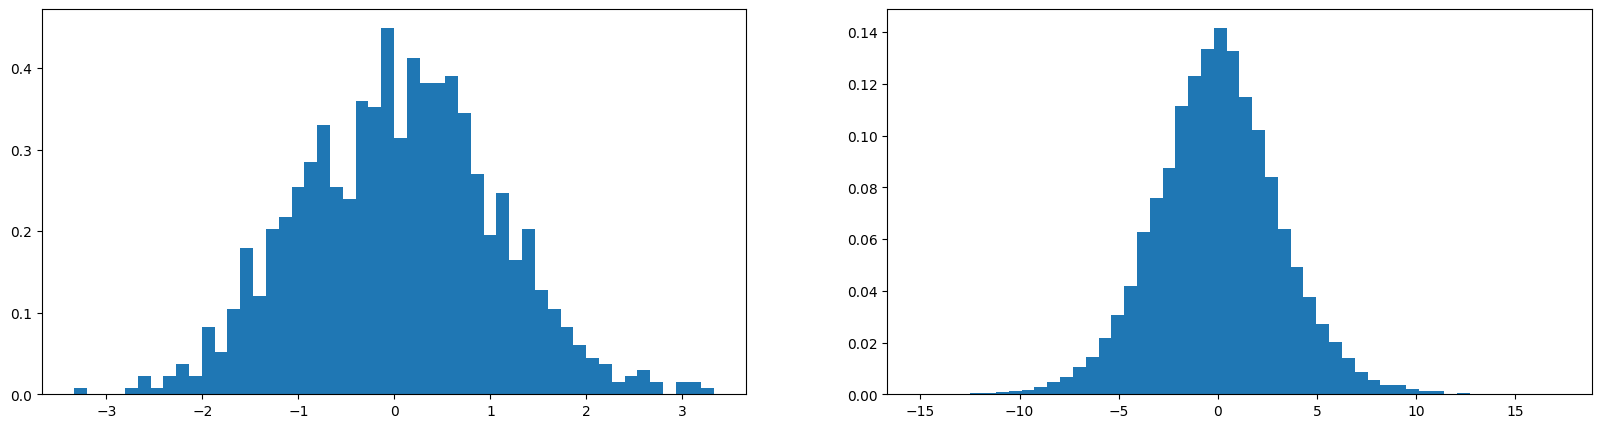

In [152]:
x = torch.randn(100,10)
w = torch.randn(10,200)
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

# tensor(-0.0004) tensor(1.0044)
# tensor(-0.0046) tensor(3.1494) You can see how std of guassain increases in nn
# we need uniform guassian throught nn and not increase std
# so what do multiply --> w = torch.randn(10,200) * n <-- with to create similar std ??
# divde by sqt of fan_in
# w = torch.randn(10,200) / 10 * 0.5

# torch.init.kaiming_normal
# Kaiming initialization (also known as He initialization) is a weight initialization method in PyTorch, primarily designed for neural networks that use ReLU or its variants as activation functions. It helps mitigate the vanishing or exploding gradient problems during training.
# torch.nn.init.kaiming_normal_(tensor, a=0, mode='fan_in', nonlinearity='leaky_relu', generator=None)
# he method is described in Delving deep into rectifiers.
# The resulting tensor will have values sampled from N(0,std^2) where std = gain / 0.5 * fan_in
# var = 1 / fan_in
# standard deviation std is determined by the gain and the number of input connections (fan_in)
# Assume: Inputs have variance = 1, We want outputs to also have variance ≈ 1
# ReLU keeps only positive half of a symmetric distribution, So variance is halved, This is why Kaiming uses √2 for ReLU

| **Nonlinearity**         | **Gain**                                          |
| ------------------------ | ------------------------------------------------- |
| Linear / Identity        | 1                                                 |
| Conv1D / Conv2D / Conv3D | 1                                                 |
| Sigmoid                  | 1                                                 |
| Tanh                     | ( \dfrac{5}{3} )                                  |
| ReLU                     | ( \sqrt{2} )                                      |
| Leaky ReLU               | ( \sqrt{\dfrac{2}{1 + \text{negative_slope}^2}} ) |
| SELU                     | ( \dfrac{3}{4} )                                  |



In [153]:
# Previously it was v imp to initilise carefully 
# now many inovation have made them deemed less imp 
# such as residual networks , batch norm , better optimizers 

# even better initialisation / compensating for std

In [154]:
# MLP revisited
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)  # for reproducibility

C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/(n_embd * block_size) ** 0.5
b1 = torch.randn(n_hidden, generator=g) * 0.01  # little bit of entropy / variation
W2 = (
    torch.randn((n_hidden, vocab_size), generator=g) * 0.01
)  # need no bias at initialisation,
# shouldnt do 0 because
b2 = torch.randn(vocab_size, generator=g) * 0  # w2 impacts logits hence decreasing

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))  # number of parameters in total

for p in parameters:
    p.requires_grad = True

11897


In [155]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y

    # forward pass
    emb = C[Xb]  # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1)  # concatenate the vectors
    hpreact = embcat @ W1 + b1  # hidden layer pre-activation
    h = torch.tanh(hpreact)  # hidden layer
    logits = h @ W2 + b2  # output layer
    loss = F.cross_entropy(logits, Yb)  # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:  # print every once in a while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 3.3179
  10000/ 200000: 2.1910
  20000/ 200000: 2.3270
  30000/ 200000: 2.5396
  40000/ 200000: 1.9468
  50000/ 200000: 2.3331
  60000/ 200000: 2.3852
  70000/ 200000: 2.1173
  80000/ 200000: 2.3159
  90000/ 200000: 2.2010
 100000/ 200000: 1.8591
 110000/ 200000: 2.0881
 120000/ 200000: 1.9389
 130000/ 200000: 2.3913
 140000/ 200000: 2.0949
 150000/ 200000: 2.1458
 160000/ 200000: 1.7824
 170000/ 200000: 1.7249
 180000/ 200000: 1.9752
 190000/ 200000: 1.8614


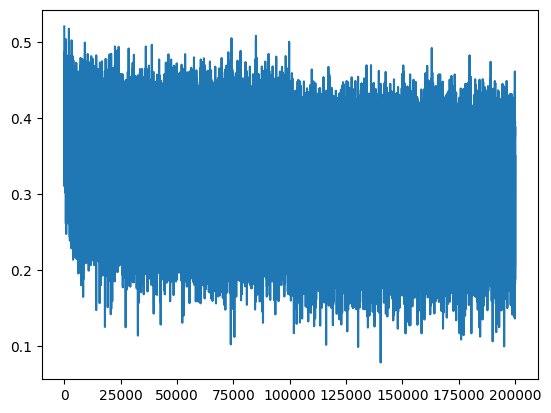

In [156]:
plt.plot(lossi)

In [157]:
@torch.no_grad()  # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]

    emb = C[x]  # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1)  # concat into (N, block_size * n_embd)
    h = torch.tanh(embcat @ W1 + b1)  # (N, n_hidden)
    logits = h @ W2 + b2  # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


# faster convergence and better results because we are spending more steps optimising nn instead of squashing weights
split_loss("train")
split_loss("val")

train 2.0376641750335693
val 2.106989622116089


## batch normalisation 

idea: just normalise them to be guassian 

In [159]:
# initilaise to have guassain 
# however not always 

In [173]:
# MLP revisited
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)  # for reproducibility

C = torch.randn((vocab_size, n_embd), generator=g)
W1 = (
    torch.randn((n_embd * block_size, n_hidden), generator=g)
    * (5 / 3)
    / (n_embd * block_size) ** 0.5
)
# b1 = torch.randn(n_hidden, generator=g) * 0.01  # little bit of entropy / variation
W2 = (
    torch.randn((n_hidden, vocab_size), generator=g) * 0.01
)  # need no bias at initialisation,
# shouldnt do 0 because
b2 = torch.randn(vocab_size, generator=g) * 0  # w2 impacts logits hence decreasing

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1,n_hidden))

# guassian initial for running , updated on side of training / training not effected
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

# parameters = [C, W1, b1, W2, b2, bngain, bnbias]
parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))  # number of parameters in total

for p in parameters:
    p.requires_grad = True

12097


In [174]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y

    # forward pass
    emb = C[Xb]  # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1)  # concatenate the vectors

    # no use of bias since we take mean and subtract it , it essentially gets removed
    hpreact = embcat @ W1 # + b1  # hidden layer pre-activation
    # HENCE REMOVE BIAS WEIGHTS FROM LAYERS WE DO BATCH NORM ON
    # BATCH NORM HAS ITS OWN BIAS WHICH REPLACES THIS

    # shouldnt be forced to be guassian so we do a scale and shift
    # we do scale and shift to allow distribution to take any shape (sharp, diffuse , movearound- not be at 0 mean)
    # these scale and shift are traine with backprop
    # required at every linear layer
    # hpreact = bngain *  ((hpreact - hpreact.mean(dim=0, keepdim=True)) / hpreact.std(dim=0 , keepdim=True)) + bnbias

    # -----BATCH NORM LAYER--------
    bnmeani = hpreact.mean(dim=0, keepdim=True)
    bnstdi = hpreact.std(dim=0 , keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    # -----------------------------

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    h = torch.tanh(hpreact)  # hidden layer
    logits = h @ W2 + b2  # output layer

    # now loss grad changes depends on batch and not only the sample itself
    # this is good because it avoids overfitting on example / regularizing effect
    loss = F.cross_entropy(logits, Yb)  # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:  # print every once in a while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 3.3239
  10000/ 200000: 2.0322
  20000/ 200000: 2.5675
  30000/ 200000: 2.0125
  40000/ 200000: 2.2446
  50000/ 200000: 1.8897
  60000/ 200000: 2.0785
  70000/ 200000: 2.3681
  80000/ 200000: 2.2918
  90000/ 200000: 2.0238
 100000/ 200000: 2.3673
 110000/ 200000: 2.3132
 120000/ 200000: 1.6414
 130000/ 200000: 1.9311
 140000/ 200000: 2.2231
 150000/ 200000: 2.0027
 160000/ 200000: 2.0997
 170000/ 200000: 2.4949
 180000/ 200000: 2.0199
 190000/ 200000: 2.1707


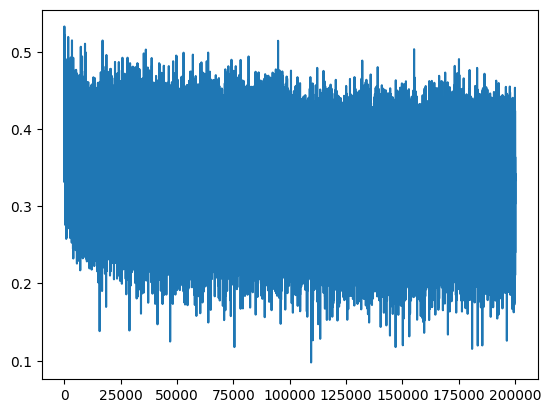

In [175]:
plt.plot(lossi)

### step after training to get fixed batch mean and std

In [176]:
# calibrate the batch norm at the end of training
with torch.no_grad():

    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1

    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

# THIS IS ALSO A EXTRA STEP 
# SO THE PROPOSED APPROACH IS TO GO FOR RUNNING-MEAN AND STD AND USE THAT

In [179]:
@torch.no_grad()  # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]

    emb = C[x]  # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1)  # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 #+ b1

    # nn expects batches now which is bad if we want a single sample inference
    # DONT ESTIMATE DYNAMICALLY
    # hpreact = (
    #     bngain
    #     * (hpreact - hpreact.mean(0, keepdim=True))
    #     / hpreact.std(0, keepdim=True)
    #     + bnbias
    # )
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact)  # (N, n_hidden)
    logits = h @ W2 + b2  # (N, vocab_size)
    loss = F.cross_entropy(logits, y)

    print(split, loss.item())


split_loss("train")
split_loss("val")

train 2.0674145221710205
val 2.1056838035583496


In [180]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size  # initialize with all ...

    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])]  # (1, block_size, n_embd)
        embcat = emb.view(emb.shape[0], -1)
        hpreact = embcat @ W1 # + b1
        hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)

        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()

        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)

        # if we sample the special '.' token, break
        if ix == 0:
            break

    # decode and print the generated word
    print("".join(itos[i] for i in out))

carlah.
amorie.
khi.
mri.
reity.
salaysie.
mahnen.
delynn.
jareei.
ner.
kiah.
maiivia.
leigh.
ham.
joce.
quint.
salin.
alianni.
wate.
madiaryn.
